# This notebook downloads the Places365 Dataset and creates a framework using the dataset to make the dataset conducive to be used for training.

## Section 1 Downloading ,Setting Up Data and Creating Validation and Test Suits
*   **Downloads** the training Dataset from Public Google Drive and decompressing the same
*   **Creates a directory structure with 365 directories and images under same for ease of use with tensorflow.**
**  Directory name will be the LABELS.
**  This new directory structure will have only symbolic links to the original downloaded dataset.
** Original directory structure is not conducive to use directly with tensorflow as for some categories of scenes, it has multiple directory levels.
*  Create validation and test data sets using tensorflow
*  Parse the  metadata file for decimal (0-364) to string   LABEL mapping


## Section 2 Data Analysis/Transformation

*  Decode JPEG Image
*  Resize the image to 224x224 for CNN
*  Plot the image
---


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sys
import os
import re
import gdown  #needed to dowload files from Public Google Drive
import tarfile
import re

## **Section 1 Downloading ,Setting Up Data and Creating Validation and Test Suits**

## Download the dataset and meta data files. The meta datafiles provide the decimal (0-364) to string LABEL mappings.
1. Full training dataset 1.8 million images, across 365 catgories
2. Categories_places365.txt file providing the mapping of decimal to string LABELS
## Files that are compressed are de-compressed.

In [2]:
filenames=["train_256_places365standard","categories_places365" ]
filetypes=[ ".tar", ".txt"]
file_gdrive_download=[ True,True] #repo or gdrive
file_compressed=[True,False]
file_ids_gdrive=["1pgcy8-6vV4m3Uhv0zxanPFX0c0p3kfLZ","1kTfqJo-AXG7wfmFEvYNKE0d225cYd7bg"]

In [3]:
for no, file in enumerate(filenames):
  if (file_gdrive_download[no]): #file resides in google drive
      #construct the filename
      fname= file+ filetypes[no]

      print("Downloading {}".format(fname))

      #download from google drive
      url = 'https://drive.google.com/u/0/uc?id={}'.format(file_ids_gdrive[no])
      gdown.download(url, os.path.join(os.getcwd(),fname), quiet=False)

      #untar it if the file needs untar
      if(file_compressed[no]):
        #open tar file in read mode
        file_obj = tarfile.open(os.path.join(os.getcwd(),fname),"r")

        #extract the tar file
        file = file_obj.extractall()

        #close file
        file_obj.close()
  else:
    
    print("Using from repo {}".format(file))


Downloading...
From: https://drive.google.com/u/0/uc?id=1pgcy8-6vV4m3Uhv0zxanPFX0c0p3kfLZ
To: /content/train_256_places365standard.tar
100%|██████████| 26.1G/26.1G [06:09<00:00, 70.7MB/s]


Downloading...
From: https://drive.google.com/u/0/uc?id=1kTfqJo-AXG7wfmFEvYNKE0d225cYd7bg
To: /content/categories_places365.txt
100%|██████████| 6.83k/6.83k [00:00<00:00, 2.64MB/s]


In [4]:
devices = tf.config.list_physical_devices()
print(devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Record the file paths of the downloaded data

In [5]:
#original downloaded dataset directory
org_dir= os.path.join(os.getcwd(), "data_256")
org_cat_dir=os.path.join(os.getcwd(), "categories_places365.txt")

#directory to produce symbolic link
gen_dir=os.path.join(os.getcwd(), "places365")

assert(os.path.exists(org_dir))
assert(os.path.exists(org_cat_dir))
print("Original Downloaded Dataset at :{}".format(org_dir))
print("Original Categories Mapping file  (decimal to string labesls mapping) :{}".format(org_cat_dir))

Original Downloaded Dataset at :/content/data_256
Original Categories Mapping file  (decimal to string labesls mapping) :/content/categories_places365.txt


In [6]:
#Open categories text file providing list of dirs and the numeric label
try:
    org_cat_file= open(org_cat_dir,"r")
except:
    print("Cannot open original categories file {}\n".format(org_cat_dir))
    sys.exit(1)

##Directory Structure
## The original directory structure is not conducive for traning as it has multiple layers of directories
## For Tensorflow based training, requirement is to have only one level directory structure where the directory name is the LABEL and the images for that category are under the label
## This piece of code, create the required directory structure. In doing so, only symbolic links are created to the originally downloaded data. This way only one downloaded copy of the dataset exists.

### First the original directory structure is parsed and two lists are maintained, those images with one level hierarchy and those with multi-level hierarchies.
### For directories with multiple levels of hierarchies, we concatinate the last two directory names to cut down the directory levels

In [7]:
#counts    
all=0
nested_dir=0
single_dir=0


#list
dir_list=[]
label_list=[]
nlabel_list=[]
dir_nested_list=[]
img_cnt_list=[]


for line in org_cat_file.readlines():
    nested=False
    all+=1
    dir2=re.match("^\s*(\/(\w+)\/(\w+)\/(\w+))\s+(\d+)\s*$",line)
    dir1=re.match("^\s*(\/(\w+)\/(\w+))\s+(\d+)\s*$",line)
    if (dir2):
        nested_dir +=1
        nested=True       
    elif (dir1):
        single_dir+=1
    else:
        continue

    if nested:
        cdir=dir2.group(1)
        clabel=dir2.group(3)+ "__"+dir2.group(4)
        cnlabel=dir2.group(5)
        cnested=True
    else:
        cdir=dir1.group(1)
        clabel=dir1.group(3)
        cnlabel=dir1.group(4)
        cnested=False
        
    full_dir=org_dir+cdir#os.path.join(org_dir,cdir)
    if(os.path.exists(full_dir)):
        #count the number of images in the dir
        img_cnt_list.append(len(os.listdir(full_dir)))
        dir_list.append(cdir)
        label_list.append(clabel)
        nlabel_list.append(cnlabel)
        dir_nested_list.append(cnested)
    else:
        print("Error: {} directory does not exist! {} and {}\n".format(full_dir, org_dir,cdir))
        sys.exit(1)
        


In [8]:
#print and check outputs
print("Categories with nested dirs={}\nCategories with dirs={}\nTotal categories={}".format(nested_dir,single_dir,all))
assert(nested_dir+single_dir==all)

#generate pandas dataframe from parsed list.
cat_df= pd.DataFrame({
                      "label":label_list,
                     "num_label":nlabel_list,
                     "image_count":img_cnt_list,
                     "dir":dir_list,
                     "nested_dir":dir_nested_list})

Categories with nested dirs=75
Categories with dirs=290
Total categories=365


In [9]:
print(cat_df.drop(["image_count"], axis=1).describe())
print(cat_df.columns)

           label num_label          dir nested_dir
count        365       365          365        365
unique       365       365          365          2
top     airfield         0  /a/airfield      False
freq           1         1            1        290
Index(['label', 'num_label', 'image_count', 'dir', 'nested_dir'], dtype='object')


In [10]:
#create required dir structure.
if(os.path.exists(gen_dir)):
    print("INFO:Directory already exists, will not be recreated! {}".format(full_dir))
else:
    os.mkdir(gen_dir)

## Code below creates the required one hierarchy directory structure.
## If the directory already exists (prior run) then the same is used.

In [11]:
#for every label create  a symbolic link
org_work_dir=os.getcwd()
print(org_work_dir)
os.chdir(gen_dir)
print("Script changed to dir {}".format(gen_dir))

#create symbolic links to each label.
for number,clabel in enumerate(label_list):
    dir_tobe_linked= org_dir +dir_list[number]
    dir_link=clabel
    if (os.path.exists(dir_link)):
        print("EXISTS {} -> {}".format(clabel,dir_tobe_linked))
    else:
        os.symlink(dir_tobe_linked,dir_link)
        print("NEW {} -> {}".format(clabel,dir_tobe_linked))
os.chdir(org_work_dir)
print(os.getcwd())

/content
Script changed to dir /content/places365
NEW airfield -> /content/data_256/a/airfield
NEW airplane_cabin -> /content/data_256/a/airplane_cabin
NEW airport_terminal -> /content/data_256/a/airport_terminal
NEW alcove -> /content/data_256/a/alcove
NEW alley -> /content/data_256/a/alley
NEW amphitheater -> /content/data_256/a/amphitheater
NEW amusement_arcade -> /content/data_256/a/amusement_arcade
NEW amusement_park -> /content/data_256/a/amusement_park
NEW apartment_building__outdoor -> /content/data_256/a/apartment_building/outdoor
NEW aquarium -> /content/data_256/a/aquarium
NEW aqueduct -> /content/data_256/a/aqueduct
NEW arcade -> /content/data_256/a/arcade
NEW arch -> /content/data_256/a/arch
NEW archaelogical_excavation -> /content/data_256/a/archaelogical_excavation
NEW archive -> /content/data_256/a/archive
NEW arena__hockey -> /content/data_256/a/arena/hockey
NEW arena__performance -> /content/data_256/a/arena/performance
NEW arena__rodeo -> /content/data_256/a/arena/ro

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
print(tf.__version__)
#verify gpu
devices = tf.config.list_physical_devices()
print(devices)
from tensorflow.keras import models,layers
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import  confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import top_k_accuracy_score

2.8.2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## **Train and Validation Data Creation**
## Create test and validation suite in 80:20 ration using Tensorflow
### Since directory name is same as label, tensorflow routines are used to directly read the images and interpret the directory name as LABEL.

In [13]:
indir=gen_dir
tar_height=224
tar_width=224
batch_size=32

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  indir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(tar_height, tar_width),
  batch_size=batch_size,
  shuffle=True
)
val_ds = tf.keras.utils.image_dataset_from_directory(
  indir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(tar_height, tar_width),
  batch_size=batch_size,
  shuffle=True #can this help
)

Found 1803460 files belonging to 365 classes.
Using 1442768 files for training.
Found 1803460 files belonging to 365 classes.
Using 360692 files for validation.


## Check if the total number of labels is 365

In [15]:
train_labels=train_ds.class_names
print(len(train_labels))

365


### **Get Mapping of Categorical Label to Decimal Numbers**
    1.categories_places365.txt:  This is  released part of original  dataset
   
    2.Each line contains
        <alphabet>/<label>                   <numeric_category>
        OR
        <alphabet>/<label>/<indoor|outdoor>  <numeric_categroy>
        
    3. Code below parses the same and creates a dictionary with "numeric category" 
    (0-364)  as key and string label as value.
    
    4. Sample lines from the file
    
    /b/barn 40
    /b/barndoor 41
    /b/baseball_field 42
    /b/basement 43
    /b/basketball_court/indoor 44
    /b/bathroom 45

In [16]:
lfile=open (org_cat_dir, 'r')

In [17]:
golden_categories={}
for line in lfile.readlines():
    dir2=re.match("^\s*(\/(\w+)\/(\w+)\/(\w+))\s+(\d+)\s*$",line)
    dir1=re.match("^\s*(\/(\w+)\/(\w+))\s+(\d+)\s*$",line)
    if (dir2):
        cdir=dir2.group(1)                           #alphabet
        clabel=dir2.group(3)+ "__"+dir2.group(4)     #categorical name
        cnlabel=dir2.group(5)                        #numeric value
    else:
        cdir=dir1.group(1)                           #alphabet
        clabel=dir1.group(3)                         #categorical name
        cnlabel=dir1.group(4)                        #numeric value
    #print(cnlabel, clabel)
    golden_categories[int(cnlabel)]=clabel

---
## Section 2 Data Analysis/Transformation


### Dictionary below has decimal (0-364) to string label mapping for various categories

In [24]:
print("Decimal to String LABEL mapping:\n",golden_categories)

Decimal to String LABEL mapping:
 {0: 'airfield', 1: 'airplane_cabin', 2: 'airport_terminal', 3: 'alcove', 4: 'alley', 5: 'amphitheater', 6: 'amusement_arcade', 7: 'amusement_park', 8: 'apartment_building__outdoor', 9: 'aquarium', 10: 'aqueduct', 11: 'arcade', 12: 'arch', 13: 'archaelogical_excavation', 14: 'archive', 15: 'arena__hockey', 16: 'arena__performance', 17: 'arena__rodeo', 18: 'army_base', 19: 'art_gallery', 20: 'art_school', 21: 'art_studio', 22: 'artists_loft', 23: 'assembly_line', 24: 'athletic_field__outdoor', 25: 'atrium__public', 26: 'attic', 27: 'auditorium', 28: 'auto_factory', 29: 'auto_showroom', 30: 'badlands', 31: 'bakery__shop', 32: 'balcony__exterior', 33: 'balcony__interior', 34: 'ball_pit', 35: 'ballroom', 36: 'bamboo_forest', 37: 'bank_vault', 38: 'banquet_hall', 39: 'bar', 40: 'barn', 41: 'barndoor', 42: 'baseball_field', 43: 'basement', 44: 'basketball_court__indoor', 45: 'bathroom', 46: 'bazaar__indoor', 47: 'bazaar__outdoor', 48: 'beach', 49: 'beach_hous

In [25]:
print("Total Categories ={}".format(len(golden_categories)))

Total Categories =365


### ***Image Data Transformation***
1. ### Decode each and every image in training set (1.8 million images)  into 3 channels
2. ### Downscale the image to 224x224 



---



In [33]:
import matplotlib.pyplot as plt

In [28]:
category_dirs=os.listdir(indir)
assert(len(category_dirs)==365)

Code below reads each category directory.<br>
Reads each image in the directory.<br>
Decodes the JPEG into 3 channels.<br>
Resizes the image to 224x224.<br>

**All of these are necessary steps to be used for making data usable as input to the CNN for training.**


In [ ]:

for no,category in enumerate(category_dirs):
  cur_dir=os.path.join(indir,category_dirs[no])
  image_list=os.listdir(cur_dir)
  for cur_image in image_list:
    image_path=os.path.join(cur_dir,cur_image)
    #print(image_path)
    assert(os.path.exists(image_path))

    image = tf.io.read_file(image_path)

    #decode jpeg
    image = tf.io.decode_jpeg(image, channels=3)

    #resize the image
    image = tf.image.resize(image, [224, 224])
  print("Label:{} {} images  read, decoded and resized.".format(category.upper(),len(image_list)))

  
 

  

Label:PAGODA 5000 images  read, decoded and resized.
Label:DOWNTOWN 5000 images  read, decoded and resized.
Label:DORM_ROOM 5000 images  read, decoded and resized.
Label:BUS_INTERIOR 5000 images  read, decoded and resized.
Label:CLOTHING_STORE 5000 images  read, decoded and resized.
Label:WAVE 5000 images  read, decoded and resized.
Label:WET_BAR 5000 images  read, decoded and resized.
Label:JEWELRY_SHOP 5000 images  read, decoded and resized.
Label:FOREST__BROADLEAF 5000 images  read, decoded and resized.
Label:ARCHIVE 5000 images  read, decoded and resized.
Label:FOUNTAIN 5000 images  read, decoded and resized.
Label:AMPHITHEATER 5000 images  read, decoded and resized.
Label:HARDWARE_STORE 5000 images  read, decoded and resized.
Label:BOW_WINDOW__INDOOR 5000 images  read, decoded and resized.
Label:AIRFIELD 5000 images  read, decoded and resized.
Label:VOLCANO 5000 images  read, decoded and resized.
Label:ATHLETIC_FIELD__OUTDOOR 5000 images  read, decoded and resized.
Label:LOCK_CHAM

## Plotting few images for sanity
### Randomly select 9 categories and plot random image from the same
### Different random images will be displayed everytime this cell is run

In [54]:
import random

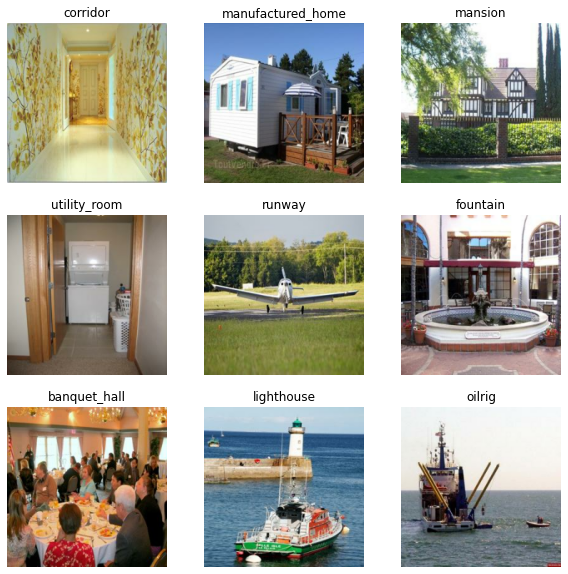

In [57]:
# create figure
fig = plt.figure(figsize=(10, 10))
  
# setting values to rows and column variables
rows = 3
columns = 3

for i in range(9):
  #pick random category
  cur_category=random.choice(category_dirs) #use random category
  cur_dir=os.path.join(indir,cur_category)

  image_list=os.listdir(cur_dir)
  #pick random image in the category
  image_path=os.path.join(cur_dir,random.choice(image_list))

  assert(os.path.exists(image_path))
  
  #read and transform the image
  image = tf.io.read_file(image_path)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224, 224])

  #transform to uint8
  image = tf.cast(image, tf.uint8)

  #plot the image
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(cur_category)
